# AIPI 590 - XAI | Assignment #01
### Leo Chen

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Leo-ChenYZ/Explainable-AI/blob/main/Assignments/Assignment_1/Assignment_1.ipynb)

👉 Make sure to delete the helper markdown below in your own notebook!

## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable-AI" # Change to your repo name
git_path = 'https://github.com/Leo-ChenYZ/Explainable-AI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignments/Assignment_1'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'Explainable-AI'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 168.98 KiB | 7.35 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/Explainable-AI/Assignments/Assignment_1
Assignment_1.ipynb  README.md  WA_Fn-UseC_-Telco-Customer-Churn.csv


## Exploratory Data Analysis to check Assumptions

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix
from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.smooth_basis import BSplines

In [4]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [5]:
# clean TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

df["Churn_flag"] = df["Churn"].map({"Yes":1, "No":0})

In [7]:
# correlation matrix for numeric variables with churn
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()["Churn_flag"].sort_values(ascending=False)
print(corr.reset_index())

            index  Churn_flag
0      Churn_flag    1.000000
1  MonthlyCharges    0.193356
2   SeniorCitizen    0.150889
3    TotalCharges   -0.199037
4          tenure   -0.352229


In [8]:
# churn distribution by categorical features (Chi-square test for independence)
chi2_results = []
categorical_cols = df.select_dtypes(include=["object"]).columns.drop("customerID")
for col in categorical_cols:
    ct = pd.crosstab(df[col], df["Churn_flag"])
    chi2, p, dof, expected = stats.chi2_contingency(ct)
    chi2_results.append((col, chi2, p))

chi2_df = pd.DataFrame(chi2_results, columns=["feature","chi2","p_value"]).sort_values("p_value")
print(chi2_df)

             feature         chi2        p_value
15             Churn  7037.871379   0.000000e+00
12          Contract  1184.596572  5.863038e-258
6     OnlineSecurity   849.998968  2.661150e-185
9        TechSupport   828.197068  1.443084e-180
5    InternetService   732.309590  9.571788e-160
14     PaymentMethod   648.142327  3.682355e-140
7       OnlineBackup   601.812790  2.079759e-131
8   DeviceProtection   558.419369  5.505219e-122
11   StreamingMovies   375.661479   2.667757e-82
10       StreamingTV   374.203943   5.528994e-82
13  PaperlessBilling   258.277649   4.073355e-58
2         Dependents   189.129249   4.924922e-43
1            Partner   158.733382   2.139911e-36
4      MultipleLines    11.330441   3.464383e-03
3       PhoneService     0.915033   3.387825e-01
0             gender     0.484083   4.865787e-01


In [9]:
# logistic assumption check (linearity in the logit)
logit_assumptions = []
for col in numeric_cols:
    if col != "Churn_flag":
        # Add a small constant to avoid log(0)
        temp = df[[col,"Churn_flag"]].copy()
        temp[col+"_log"] = temp[col].apply(lambda x: np.log(x+1) if x>=0 else 0)
        corr_val, p_val = stats.pearsonr(temp[col]*temp[col+"_log"], temp["Churn_flag"])
        logit_assumptions.append((col, corr_val, p_val))

logit_df = pd.DataFrame(logit_assumptions, columns=["feature","corr_interaction","p_value"]).sort_values("p_value")
print(logit_df)

          feature  corr_interaction        p_value
1          tenure         -0.342271  8.686489e-193
3    TotalCharges         -0.193682   1.703691e-60
2  MonthlyCharges          0.188683   1.889571e-57
0   SeniorCitizen          0.150889   3.839860e-37


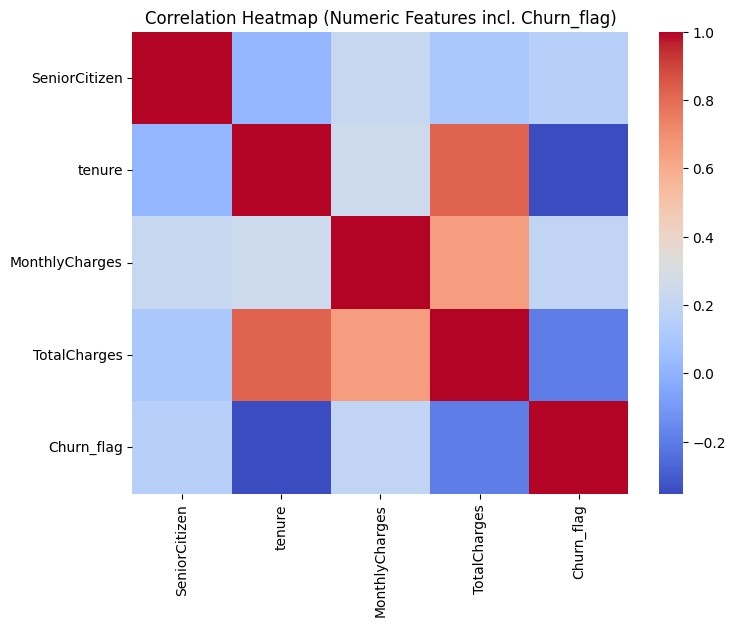

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features incl. Churn_flag)")
plt.show()

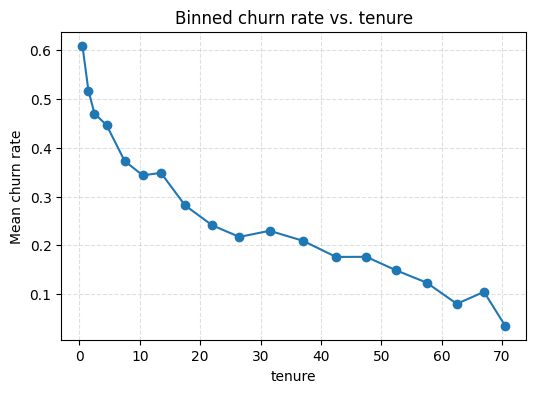

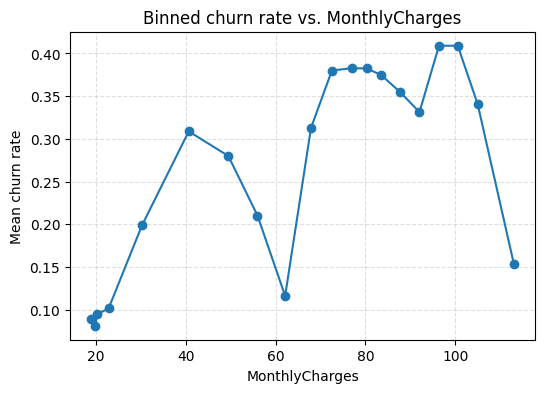

In [11]:
# GAM: binned churn-rate curves
def plot_binned_rate(frame, xcol, ycol="Churn_flag", q=20):
    bins = pd.qcut(frame[xcol], q=q, duplicates="drop")
    grp = frame.groupby(bins, observed=True)[ycol].mean().reset_index()
    mids = [(float(iv.strip("()[]").split(",")[0]) +
             float(iv.strip("()[]").split(",")[1]))/2 for iv in grp[xcol].astype(str)]
    grp["mid"] = mids

    plt.figure(figsize=(6,4))
    plt.plot(grp["mid"], grp[ycol], marker="o")
    plt.xlabel(xcol)
    plt.ylabel("Mean churn rate")
    plt.title(f"Binned churn rate vs. {xcol}")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

plot_binned_rate(df, "tenure")
plot_binned_rate(df, "MonthlyCharges")

Linear Regression: Linearity violated - churn is categorical (0/1). Also some service features seem to be correlated.

Logistic Regression: Numeric features (e.g., tenure, MonthlyCharges) should relate linearly to log-odds of churn, but tenure and charges do not follow strict linearity. Also some categorical dummies are correlated.

GAM: Everything looks good. Churn varies nonlinearly with tenure/charges.

## Linear Regression

In [13]:
X = pd.get_dummies(df.drop(columns=["customerID", "Churn", "Churn_flag"]), drop_first=True, dtype=int)
y = df["Churn_flag"]

X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const)
ols_res = ols_model.fit()

y_pred = ols_res.predict(X_const)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

# coefficients by significance
coef_df = pd.DataFrame({
    "term": ols_res.params.index,
    "coef": ols_res.params.values,
    "p_value": ols_res.pvalues
}).sort_values("p_value")

print("Linear Regression coefficients (sorted by significance)", coef_df)
print()
print(f"R²:   {r2:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print()
print(ols_res.summary())

Linear Regression coefficients (sorted by significance)                                                                         term  \
MultipleLines_No phone service                MultipleLines_No phone service   
Contract_One year                                          Contract_One year   
TotalCharges                                                    TotalCharges   
PaymentMethod_Electronic check                PaymentMethod_Electronic check   
PaperlessBilling_Yes                                    PaperlessBilling_Yes   
Contract_Two year                                          Contract_Two year   
tenure                                                                tenure   
SeniorCitizen                                                  SeniorCitizen   
const                                                                  const   
MultipleLines_Yes                                          MultipleLines_Yes   
InternetService_Fiber optic                      InternetService

Longer contracts are strongly protective against churn. Electronic check users are more likely to churn. Senior citizens are more likely to churn. Longer tenure reduces churn.

Performance:
- the model explains ~28% of the variance in churn
- predictions are quite noisy
- OLS is useful here mainly for interpretability; logistic regression or GAM is more appropriate for predictive accuracy

## Logistic Regression

In [15]:
logit_model = sm.GLM(y, X_const, family=sm.families.Binomial())
logit_res = logit_model.fit()

y_pred_prob = logit_res.predict(X_const)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

auc = roc_auc_score(y, y_pred_prob)
acc = accuracy_score(y, y_pred_class)
cm = confusion_matrix(y, y_pred_class)

coef_df = pd.DataFrame({
    "term": logit_res.params.index,
    "coef": logit_res.params.values,
    "odds_ratio": np.exp(logit_res.params.values),
    "p_value": logit_res.pvalues
}).sort_values("p_value")

print("Logistic Regression coefficients (with odds ratios)", coef_df)
print()
print(f"AUC:      {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)
print()
print(logit_res.summary())

Logistic Regression coefficients (with odds ratios)                                                                         term  \
tenure                                                                tenure   
Contract_Two year                                          Contract_Two year   
Contract_One year                                          Contract_One year   
PaperlessBilling_Yes                                    PaperlessBilling_Yes   
TotalCharges                                                    TotalCharges   
PaymentMethod_Electronic check                PaymentMethod_Electronic check   
MultipleLines_No phone service                MultipleLines_No phone service   
SeniorCitizen                                                  SeniorCitizen   
MultipleLines_Yes                                          MultipleLines_Yes   
OnlineBackup_No internet service            OnlineBackup_No internet service   
OnlineSecurity_No internet service        OnlineSecurity_No internet

Longer contracts strongly reduce churn (one-year customers have about half the odds, two-year customers about one-quarter the odds compared to month-to-month). Electronic check and paperless billing both increase churn risk (≈1.3–1.4× odds), while fiber optic internet customers are far more likely to churn (≈5.8× odds) than DSL users. Senior citizens face modestly higher odds (~1.2×), whereas longer tenure consistently lowers churn odds (≈6% reduction per month). These patterns highlight that contract type, payment method, internet service, and tenure are the strongest churn drivers.

## Generalized Additive Model (GAM)

In [17]:
# smooth variables
X_smooth = df[["tenure", "MonthlyCharges"]].values
y = df["Churn_flag"].values

# linear categorical predictors (subset to avoid singularities)
keep_cats = ["Contract", "InternetService", "PaymentMethod", "PaperlessBilling"]
categorical = pd.get_dummies(df[keep_cats], drop_first=True, dtype=int)
linear_terms = pd.DataFrame({"SeniorCitizen": df["SeniorCitizen"].astype(int)})
X_linear = pd.concat([linear_terms, categorical], axis=1)
X_linear_const = sm.add_constant(X_linear, has_constant='add')

bs = BSplines(X_smooth, df=[10, 10], degree=[3, 3])
gam_model = GLMGam(y, exog=X_linear_const, smoother=bs, family=sm.families.Binomial())
gam_res = gam_model.fit()

coef_df = pd.DataFrame({
    "term": gam_res.params.index,
    "coef": gam_res.params.values,
    "odds_ratio": np.exp(gam_res.params.values),
    "p_value": gam_res.pvalues
}).sort_values("p_value")

print("GAM linear-part coefficients (with odds ratios)", coef_df)
print()
print(gam_res.summary())

GAM linear-part coefficients (with odds ratios)                                                                         term  \
Contract_Two year                                          Contract_Two year   
x0_s8                                                                  x0_s8   
Contract_One year                                          Contract_One year   
x0_s6                                                                  x0_s6   
x0_s3                                                                  x0_s3   
PaperlessBilling_Yes                                    PaperlessBilling_Yes   
x0_s4                                                                  x0_s4   
x0_s5                                                                  x0_s5   
InternetService_Fiber optic                      InternetService_Fiber optic   
x0_s1                                                                  x0_s1   
x0_s7                                                                  x

There are both nonlinear and categorical effects on churn. The smooth spline terms for tenure show that churn risk is highest in the early months, then drops sharply and stabilizes over time, confirming a strong nonlinear pattern. For MonthlyCharges, most spline terms are not significant, suggesting a weaker/flatter nonlinear effect. Among linear predictors, customers on longer contracts are much less likely to churn (odds reduced by ~55% for one-year and ~80% for two-year contracts), while fiber optic internet users, electronic check payers, paperless billing customers, and senior citizens all have higher churn risk. In contrast, customers with no internet service are a lot less likely to churn. Overall, contract type, billing/payment method, and internet service are key churn drivers.

## Model Comparison

Treating churn as continuous with *linear regression* provided some interpretability but poor predictive performance, explaining less than 1/3 of the variation and producing unrealistic predictions outside the 0-1 range. *Logistic regression* was a stronger fit, with an AUC of about 0.85 and good accuracy, and its coefficients translated naturally into odds ratios that were easy to interpret. However, it assumed linearity in numeric predictors, which the data didn't fully support. The *GAM* addressed this limitation by capturing nonlinear relationships, particularly the steep drop in churn as tenure increases in the first two years. It retained interpretability for categorical features while allowing flexible curves for numeric ones, offering both accuracy and customer behavior insights.

For the company, *logistic regression* already provides strong, interpretable results. If their goal is not only prediction but also understanding how churn risk evolves over time or with things like monthly charges, the *GAM* is preferable since it reveals nonlinear patterns that a simple logistic model cannot. My practical recommendation is to use the *logistic regression* model for day-to-day churn prediction and operational decision-making, while leveraging the *GAM* as an analytical tool.

##

##